In [ ]:
#Package Importation
import pandas as pd
import numpy as np
import re
from keras.layers import LSTM, Activation, Dropout, Dense, Input, Flatten,Embedding,  Conv1D, MaxPool1D, Bidirectional
from keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Flatten, BatchNormalization
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from google.colab import files as FILE
import os
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from keras.optimizers import Adam,RMSprop
from keras.utils.vis_utils import plot_model
from keras import regularizers
from datetime import datetime


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving data.xlsx to data.xlsx


In [ ]:
df = pd.read_excel('data.xlsx')
df.columns


Index(['text', 'label'], dtype='object')

In [ ]:
df.columns

Index(['text', 'label'], dtype='object')

Remote tweets with null values

In [ ]:
df = df[df['text'].notna()]#remove null value

Remove the positive and negative emotions from the data

In [ ]:
df=df.drop(df[df['Emotion']=='positive'].index)
df=df.drop(df[df['Emotion']=='negative'].index)

In [ ]:
#Check Total
print("Number of tweets: {}".format(len(df)))

Number of tweets: 6972


In [ ]:
# Print the distribution of emotions in the data
df['Emotion'].value_counts()

In [ ]:
#count of emotion
#em=df['Emotion'].value_counts()
import seaborn as sns
em = df['Emotion'].value_counts().rename_axis('emotion').reset_index(name='counts')
plt.figure(figsize=(12, 5))
plt.bar(em['emotion'], em['counts'],  width=0.8)
sns.barplot(em['emotion'], em['counts'])
#plt.savefig('em.jpg', dpi=300)
#FILE.download('em.jpg')
plt.show()

# TOKENIZATION AND PADDING OF THE TWEETS

In [ ]:
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(df['Ceext'].values)
X = tokenizer.texts_to_sequences(df['CleanText'].values)
#Y=tokenizer.texts_to_sequences(df['Emotion'].values)
#Y = pad_sequences(Y)
X = pad_sequences(X)

# ENCODING OF THE TARGET CLASSES

In [ ]:
#encode outcome
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
le = LabelEncoder()
y=le.fit_transform(df['Emotion'].values)
#y=y.reshape(-1,1)
#y = OneHotEncoder().fit_transform(y).toarray()
print(y.shape)




In [ ]:
labels= df['Emotion'].values

In [ ]:
labels_n, count = np.unique(labels,return_counts=True)

In [ ]:
print(labels_n)

['anger' 'anticipation' 'disgust' 'fear' 'joy' 'sadness' 'surprise'
 'trust']


# SPLITTING OF DATA INTO TRAINING AND TEST DATA

In [ ]:
#Split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1, stratify=y)

print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

# Printing the class distribution in the training data
# as a tuple of (class encoding, number of instances)
unique, counts = np.unique(y_train, return_counts=True)
print(list(zip(unique,counts)))

**DATA BALANCING.**

TWO DATA BALANCING STRATEGIES  ARE APPLIED

A. UPSAMPLING WITH SMOTE

B. UPSAMPLING AND DOWNSAMPLING


THE EFFECTS OF EACH STRATEGY ON THE MODEL PERFORMANCE SHOULD BE TESTED SEPARATELY, IE EITHER WITH RUN THE MODEL OF STRATEGY A OR B

In [ ]:
# UPSAMPLING WITH SMOTE
from imblearn.over_sampling import SMOTE
oversample = SMOTE(random_state=42)


X_train_o, y_train_o = oversample.fit_resample(X_train, y_train)

# Printing the class distribution in the training data after upsampling
# as a tuple of (class encoding, number of instances)
unique, counts = np.unique(y_train_o, return_counts=True)
print(unique)
print(list(zip(unique,counts)))

In [ ]:
print()

In [ ]:
# UPSAMPLING AND DOWNSAMPLING
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

over = SMOTE(random_state=42)
#under_strategy = {0:20000,1:20000,2:20000,3:20000,4:20000,5:20000,6:20000,7:20000,8:20000,9:20000}
under_strategy = {0:14382,1:14382,2:14382,3:14382,4:14382,5:14382,6:14382,7:14382}
under = RandomUnderSampler(sampling_strategy=under_strategy)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

X_train_u, y_train_u = pipeline.fit_resample(X_train, y_train)

# Printing the class distribution in the training data
# as a tuple of (class encoding, number of instances)
unique, counts = np.unique(y_train_u, return_counts=True)
print(list(zip(unique,counts)))

# **EMOTION PREDICTION**





In [ ]:
# Setting up an early stop for the model
early_stopping = EarlyStopping(patience=5,restore_best_weights=True)

In [ ]:
print(X.shape[1])



```
# This is formatted as code
```

**LSTM-EMOTION**

In [ ]:
#LSTM
#model

embed_dim = 200
max_fatures = 2000
d =0.1

model=Sequential()

model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))#model.add(Dropout(0.2))
model.add(LSTM(256,activation='relu',return_sequences=True))

model.add(Dropout(d))

model.add(LSTM(128,activation='relu'))

model.add(Dropout(d))
'''
model.add(LSTM(64,activation='relu',return_sequences=True))

model.add(Dropout(d))

model.add(LSTM(32,activation='relu',return_sequences=True))

model.add(Dropout(d))

model.add(LSTM(16,activation='relu'))

model.add(Dropout(d))
'''
model.add(Dense(250,activation='relu'))
model.add(Flatten())
model.add(Dense(8,activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',optimizer=Adam(learning_rate=0.0001),metrics=['accuracy'])
model.summary()


In [ ]:
#@title Hyperparameter Tuning LSTM
#Hyperparameter Tuning LSTM
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from keras.models import Sequential
from keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.optimizers import Adam
import numpy as np

# Define the model
def create_model(vob_size=2000, optimizer='adam', dropout=0.2,  embedding_dim=100, epochs=10, batch_size=32):

  model = Sequential()
  model.add(Embedding(vob_size,embedding_dim, input_length=X.shape[1]))
  model.add(LSTM(256,activation='relu',return_sequences=True))

  model.add(Dropout(dropout))

  model.add(LSTM(128,activation='relu',return_sequences=True))

  model.add(Dropout(dropout))

  model.add(LSTM(64,activation='relu',return_sequences=True))

  model.add(Dropout(dropout))

  model.add(LSTM(32,activation='relu',return_sequences=True))

  model.add(Dropout(dropout))

  model.add(LSTM(16,activation='relu',return_sequences=True))

  model.add(Dropout(dropout))
  model.add(Dense(250,activation='relu'))
  model.add(Flatten())
  model.add(Dense(10,activation='softmax'))
  model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
  return model

# Define the parameter grid
param_grid = {'optimizer': ['adam', 'rmsprop', 'SGD'],
              'embedding_dim': [50,100,200, 500],
              'epochs': [10,20,30, 40, 50, 100],
              'batch_size':[32,64,128, 196, 256],
              'dropout':[0.05, 0.1, 0.2, 0.3,0.5,0.5],
              'vob_size':[1000, 2000, 3000, 5000]}


# Create the KerasClassifier
model = KerasClassifier(build_fn=create_model, verbose=0)

# Create the randomized search
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, cv=3)

# Fit the randomized search
search=random_search.fit(X, y)
print( search.best_params_)
print(f'Best Score Accuracy: {search.best_score_}')

In [ ]:
#Train the LSTM model
hist_lstm=model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=128,shuffle= True, verbose=2,callbacks=[early_stopping])

In [ ]:
#Performance Metrics for LSTM
y_test_pred = np.argmax(model.predict(X_test), axis=-1)
print(f"Accuracy Score: {accuracy_score(y_test, y_test_pred) * 100:.2f}%")
print(f"F1 Score: {f1_score(y_test, y_test_pred, average='weighted') * 100:.2f}%")
print(f"Recall Score: {recall_score(y_test, y_test_pred, average='weighted') * 100:.2f}%")
print(f"Precision Score: {precision_score(y_test, y_test_pred, average='weighted') * 100:.2f}%")
from sklearn.metrics import matthews_corrcoef
print(f'MCC Score: {matthews_corrcoef(y_test, y_test_pred):.2f}%')
cm=confusion_matrix(y_test_pred, y_test,normalize='true')
cmd = ConfusionMatrixDisplay(cm, display_labels=labels_n)
fig, ax = plt.subplots(figsize=(15,15))
cmd.plot(ax=ax,cmap=plt.cm.Blues,colorbar=False)
filename ='lstm_confmx '+datetime.now().strftime("%m-%d-%Y_%H-%M-%S")+'.jpg'
plt.savefig(filename, dpi=300)
FILE.download(filename)



In [ ]:
#@title Accuracy-loss of LSTM
plt.rcParams['font.family']='Arial'
plt.rcParams['font.size']=14
plt.plot(hist_lstm.history['accuracy'])
plt.plot(hist_lstm.history['val_accuracy'])
plt.plot(hist_lstm.history['loss'])
plt.plot(hist_lstm.history['val_loss'])

plt.title('LSTM MODEL')
plt.ylabel('Accuracy/loss')
plt.xlabel('Epoch')
plt.legend(['train accuracy', 'val accuracy','train loss',' val loss'], loc='center right')
filename ='lstm_acc_loss '+datetime.now().strftime("%m-%d-%Y_%H-%M-%S")+'.jpg'

plt.savefig(filename, dpi=300)
FILE.download(filename)
plt.show()

In [ ]:
plt.rcParams['font.family']='Arial'
plt.rcParams['font.size']=14
plt.plot(hist_lstm.history['accuracy'])
plt.plot(hist_lstm.history['val_accuracy'])

plt.title('LSTM MODEL')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train accuracy', 'val accuracy'], loc='upper left')
filename ='lstm_acc'+datetime.now().strftime("%m-%d-%Y_%H-%M-%S")+'.jpg'

plt.savefig(filename, dpi=300)
FILE.download(filename)
plt.show()

In [ ]:
plt.rcParams['font.family']='Arial'
plt.rcParams['font.size']=14
plt.plot(hist_lstm.history['loss'])
plt.plot(hist_lstm.history['val_loss'])
plt.title('LSTM MODEL')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['train loss', 'val loss'], loc='upper right')
filename ='lstm_loss '+datetime.now().strftime("%m-%d-%Y_%H-%M-%S")+'.jpg'

plt.savefig(filename, dpi=300)
FILE.download(filename)
plt.show()

 **1 DCNN**

In [ ]:
d=0.5
model = Sequential()
model.add(Embedding(20000,200, input_length=X.shape[1]))
#model.add(Dropout(0.2))
model.add(Conv1D(256, 3, activation='relu', padding='same'))
model.add(MaxPool1D(2))
model.add(Dropout(d))
model.add(Conv1D(128, 3, activation='relu', padding='same'))
model.add(MaxPool1D(2))
model.add(Dropout(d))
model.add(Conv1D(128, 3, activation='relu', padding='same'))
model.add(MaxPool1D(2))
model.add(Dropout(d))
model.add(Flatten())
#model.add(Dropout(d))
model.add(Dense(256, activation='relu'))
#model.add(Dense(256, activation='relu',activity_regularizer=regularizers.l1(10e-5)))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
#model.add(Dropout(d))
model.add(Dense(8, activation='softmax'))
#model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
model.summary()



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 56, 200)           4000000   
                                                                 
 conv1d_11 (Conv1D)          (None, 56, 256)           153856    
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 28, 256)          0         
 1D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 28, 256)           0         
                                                                 
 conv1d_12 (Conv1D)          (None, 28, 128)           98432     
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 14, 128)          0         
 1D)                                                  

In [ ]:
for layer in model.layers:
        print("Layer Name: " + layer.name)
        print("Type of layer: " + layer.__class__.__name__)
        print("Input dimesion: {}".format(layer.input_shape[1:]))
        print("Output dimesion: {}".format(layer.output_shape[1:]))
        print("Parameter Count: {}".format( layer.count_params()))
        try:
            print("Activation : " + layer.activation.__name__)
            print(" ")
        except:
            print(" ")

In [ ]:
#@title Hyper parameter search for 1DCNN
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from keras.models import Sequential
from keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.optimizers import Adam
import numpy as np

# Define the model
def create_model(optimizer='adam', kernel_size=3,  pool_size=2, embedding_dim=100, epochs=10, batch_size=32):
  d=0.2
  model = Sequential()
  model.add(Embedding(20000,embedding_dim, input_length=X.shape[1]))
  model.add(Conv1D(256, 3, activation='relu', padding='same'))
  model.add(MaxPool1D(pool_size))
  model.add(Dropout(d))
  model.add(Conv1D(128, 3, activation='relu', padding='same'))
  model.add(MaxPool1D(pool_size))
  model.add(Dropout(d))
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(64, activation='relu',name='features'))
  model.add(Dense(10, activation='softmax'))
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

# Define the parameter grid
param_grid = {'optimizer': ['adam', 'rmsprop'],
              'kernel_size': [3,5],
              'pool_size': [2,3],
              'embedding_dim': [50,100,200],
              'epochs': [10,20,30],
              'batch_size':[32,64,128]}

# Create the KerasClassifier
model = KerasClassifier(build_fn=create_model, verbose=0)

# Create the randomized search
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, cv=3)

# Fit the randomized search
search=random_search.fit(X, y)
print( search.best_params_)


In [ ]:
#RUNNING THE MODEL 1D CNN  WITH BEST PARAMETER
hist1=model.fit(X_train_o, y_train_o, validation_data=(X_test,y_test), epochs=100, batch_size=32, shuffle= True, verbose=2,callbacks=[early_stopping])
#hist1=model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=200, batch_size=32, shuffle= True, verbose=2)

Epoch 1/100
20806/20806 - 114s - loss: 0.8968 - accuracy: 0.6632 - val_loss: 0.7470 - val_accuracy: 0.7819 - 114s/epoch - 5ms/step
Epoch 2/100
20806/20806 - 113s - loss: 0.6236 - accuracy: 0.7624 - val_loss: 0.4320 - val_accuracy: 0.8738 - 113s/epoch - 5ms/step
Epoch 3/100
20806/20806 - 113s - loss: 0.5332 - accuracy: 0.7983 - val_loss: 0.4529 - val_accuracy: 0.8718 - 113s/epoch - 5ms/step
Epoch 4/100
20806/20806 - 113s - loss: 0.4768 - accuracy: 0.8215 - val_loss: 0.4291 - val_accuracy: 0.8786 - 113s/epoch - 5ms/step
Epoch 5/100
20806/20806 - 113s - loss: 0.4354 - accuracy: 0.8396 - val_loss: 0.3612 - val_accuracy: 0.9000 - 113s/epoch - 5ms/step
Epoch 6/100
20806/20806 - 113s - loss: 0.4077 - accuracy: 0.8518 - val_loss: 0.3795 - val_accuracy: 0.8928 - 113s/epoch - 5ms/step
Epoch 7/100
20806/20806 - 113s - loss: 0.3828 - accuracy: 0.8618 - val_loss: 0.3558 - val_accuracy: 0.9042 - 113s/epoch - 5ms/step
Epoch 8/100
20806/20806 - 113s - loss: 0.3644 - accuracy: 0.8697 - val_loss: 0.4624

In [ ]:
from matplotlib.text import FontProperties
#Performance Metrics for 1DCNN
y_test_pred = np.argmax(model.predict(X_test), axis=-1)
print(f"Accuracy Score: {accuracy_score(y_test, y_test_pred) * 100:.2f}%")
print(f"F1 Score: {f1_score(y_test, y_test_pred, average='weighted') * 100:.2f}%")
print(f"Recall Score: {recall_score(y_test, y_test_pred, average='weighted') * 100:.2f}%")
print(f"Precision Score: {precision_score(y_test, y_test_pred, average='weighted') * 100:.2f}%")
from sklearn.metrics import matthews_corrcoef
print(f'MCC Score: {matthews_corrcoef(y_test, y_test_pred):.2f}%')
cm=confusion_matrix(y_test_pred, y_test,normalize='true')
cmd = ConfusionMatrixDisplay(cm, display_labels=labels_n)
fig, ax = plt.subplots(figsize=(15,15))
cmd.plot(ax=ax,cmap=plt.cm.Blues,colorbar=False)
filename ='dcnn_confmx '+datetime.now().strftime("%m-%d-%Y_%H-%M-%S")+'.jpg'
plt.savefig(filename, dpi=300)
FILE.download(filename)



In [ ]:
#@title Accuracy-loss of 1DCNN
plt.rcParams['font.family']='Arial'
plt.rcParams['font.size']=14
plt.plot(hist1.history['accuracy'])
plt.plot(hist1.history['val_accuracy'])
plt.plot(hist1.history['loss'])
plt.plot(hist1.history['val_loss'])

plt.title('1 DCNN MODEL')
plt.ylabel('Accuracy/loss')
plt.xlabel('Epoch')
plt.legend(['train accuracy', 'val accuracy','train loss',' val loss'], loc='center right')
filename ='dcnn_acc_loss '+datetime.now().strftime("%m-%d-%Y_%H-%M-%S")+'.jpg'

plt.savefig(filename, dpi=300)
FILE.download(filename)
plt.show()

In [ ]:
plt.rcParams['font.family']='Arial'
plt.rcParams['font.size']=14
plt.plot(hist1.history['accuracy'])
plt.plot(hist1.history['val_accuracy'])

plt.title('1 DCNN MODEL')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train accuracy', 'val accuracy'], loc='lower right')
filename ='dcnn_acc'+datetime.now().strftime("%m-%d-%Y_%H-%M-%S")+'.jpg'

plt.savefig(filename, dpi=300)
FILE.download(filename)
plt.show()

In [ ]:
plt.rcParams['font.family']='Arial'
plt.rcParams['font.size']=14
plt.plot(hist1.history['loss'])
plt.plot(hist1.history['val_loss'])
plt.title('1 DCNN MODEL')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['train loss', 'val loss'], loc='upper right')
filename ='dcnn_loss '+datetime.now().strftime("%m-%d-%Y_%H-%M-%S")+'.jpg'

plt.savefig(filename, dpi=300)
FILE.download(filename)
plt.show()

In [ ]:
#CNN-LSTM
d=0.5
model1 = Sequential()
model1.add(Embedding(20000,200, input_length=X.shape[1]))
model1.add(Dropout(0.2))
model1.add(Conv1D(256, 3, activation='relu',padding='same'))
model1.add(MaxPool1D(1))
model1.add(Dropout(d))
model1.add(BatchNormalization())
model1.add(Conv1D(128, 3, activation='relu', padding='same'))
model1.add(MaxPool1D(1))
model1.add(Dropout(d))
model1.add(BatchNormalization())
model1.add(LSTM(64, return_sequences=True))
model1.add(LSTM(32))
model1.add(Dropout(d))
#model.add(LSTM(16, return_sequences=True))
model1.add(Flatten())
model1.add(Dense(250, activation='relu'))
model1.add(Dropout(d))
model1.add(Dense(8, activation='softmax'))
model1.compile(loss='sparse_categorical_crossentropy', optimizer=RMSprop(learning_rate=0.0001), metrics=['accuracy'])
#model1.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
model1.summary()
#visualizer(model1, filename='cnn_lstm_arch',format='png', view=True)
#'pool_size': 1, 'optimizer': 'rmsprop', 'kernel_size': 3, 'epochs': 40, 'embedding_dim': 200, 'dropout': 0.1, 'batch_size': 196

In [ ]:
plot_model(model1, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
#@title Hyperparameter Tuning CNN-LSTM
#Hyperparameter Tuning CNN-LSTM
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from keras.models import Sequential
from keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.optimizers import Adam
import numpy as np

# Define the model
def create_model(optimizer='adam', kernel_size=3,  pool_size=2, dropout=0.2,  embedding_dim=100, epochs=10, batch_size=32, d=0.2):

  model = Sequential()
  model.add(Embedding(20000,embedding_dim, input_length=X.shape[1]))
  model.add(Conv1D(256, kernel_size, activation='relu', padding='same'))
  model.add(MaxPool1D(pool_size))
  model.add(Dropout(dropout))
  model.add(Conv1D(128, kernel_size, activation='relu', padding='same'))
  model.add(MaxPool1D(pool_size))
  model.add(Dropout(dropout))
  model.add(LSTM(64, return_sequences=True))
  model.add(LSTM(32))
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(10, activation='softmax'))
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

# Define the parameter grid
param_grid = {'optimizer': ['adam', 'rmsprop', 'SGD'],
              'kernel_size': [2,3,5],
              'pool_size': [1,2,3],
              'embedding_dim': [50,100,200, 500],
              'epochs': [10,20,30, 40, 50],
              'batch_size':[32,64,128, 196],
              'dropout':[0.05, 0.1, 0.2, 0.3,0.5,0.5]}

# Create the KerasClassifier
model = KerasClassifier(build_fn=create_model, verbose=0)

# Create the randomized search
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, cv=3)

# Fit the randomized search
search=random_search.fit(X, y)
print( search.best_params_)


In [ ]:
#RUNNING THE MODEL CNN-LSTM  WITH BEST PARAMETER
hist_cnnlstm=model1.fit(X_train_o, y_train_o, validation_data=(X_test,y_test), epochs=100, batch_size=128, verbose=2,callbacks=[early_stopping])
#hist2=model1.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=40, batch_size=196, verbose=2)

In [ ]:
#Performance Metrics for 1DCNN-LSTM

y_test_pred = np.argmax(model1.predict(X_test), axis=-1)
print(f"Accuracy Score: {accuracy_score(y_test, y_test_pred) * 100:.2f}%")
print(f"F1 Score: {f1_score(y_test, y_test_pred, average='weighted') * 100:.2f}%")
print(f"Recall Score: {recall_score(y_test, y_test_pred, average='weighted') * 100:.2f}%")
print(f"Precision Score: {precision_score(y_test, y_test_pred, average='weighted') * 100:.2f}%")
from sklearn.metrics import matthews_corrcoef
print(f'MCC Score: {matthews_corrcoef(y_test, y_test_pred):.2f}%')
cm=confusion_matrix(y_test_pred, y_test,normalize='true')
cmd = ConfusionMatrixDisplay(cm, display_labels=labels_n)
fig, ax = plt.subplots(figsize=(15,15))
cmd.plot(ax=ax,cmap=plt.cm.Blues,colorbar=False)
filename ='cnnlstm_confmx '+datetime.now().strftime("%m-%d-%Y_%H-%M-%S")+'.jpg'
plt.savefig(filename, dpi=300)
FILE.download(filename)

In [ ]:
#@title Accuracy-loss for CNN-LSTM
plt.rcParams['font.family']='Arial'
plt.rcParams['font.size']=14
plt.plot(hist_cnnlstm.history['accuracy'])
plt.plot(hist_cnnlstm.history['val_accuracy'])
plt.plot(hist_cnnlstm.history['loss'])
plt.plot(hist_cnnlstm.history['val_loss'])

plt.title('CNN-LSTM MODEL')
plt.ylabel('Accuracy/loss')
plt.xlabel('Epoch')
plt.legend(['train accuracy', 'val accuracy','train loss',' val loss'], loc='center right')
filename ='cnnlstm_acc_loss '+datetime.now().strftime("%m-%d-%Y_%H-%M-%S")+'.jpg'

plt.savefig(filename, dpi=300)
FILE.download(filename)
plt.show()

In [ ]:
plt.plot(hist_cnnlstm.history['accuracy'])
plt.plot(hist_cnnlstm.history['val_accuracy'])
plt.title('CNN-LSTM MODEL')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train accuracy', 'val accuracy'], loc='lower right')
filename ='cnnlstm '+datetime.now().strftime("%m-%d-%Y_%H-%M-%S")+'.jpg'

plt.savefig(filename, dpi=300)
FILE.download(filename)
plt.show()

In [ ]:
plt.rcParams['font.family']='Arial'
plt.rcParams['font.size']=14
plt.plot(hist_cnnlstm.history['loss'])
plt.plot(hist_cnnlstm.history['val_loss'])
plt.title('CNN_LSTM MODEL')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['train loss', 'val loss'], loc='upper right')
filename ='cnnlstm_loss '+datetime.now().strftime("%m-%d-%Y_%H-%M-%S")+'.jpg'

plt.savefig(filename, dpi=300)
FILE.download(filename)
plt.show()

In [ ]:
#Bidirectional LSTM
d=0.5
model3 = Sequential()
model3.add(Embedding(20000,200, input_length=X.shape[1]))
#model3.add(Dropout(0.2))
model3.add(Bidirectional(LSTM(64, return_sequences=True,recurrent_regularizer='l1')))
model3.add(Bidirectional(LSTM(64,recurrent_regularizer='l1')))
#model3.add(Bidirectional(LSTM(16,recurrent_regularizer='l1')))
model3.add(Dropout(d))
model3.add(Flatten())
model3.add(Dense(250, activation='relu'))
#model3.add(Dropout(d))
model3.add(Dense(8, activation='softmax'))
model3.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])
model3.summary()
#visualizer(model, filename='bilstm_arch',format='png', view=True)
#{'optimizer': 'rmsprop', 'epochs': 100, 'embedding_dim': 200, 'dropout': 0.1, 'batch_size': 196}

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 56, 200)           4000000   
                                                                 
 bidirectional (Bidirectiona  (None, 56, 128)          135680    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 flatten_2 (Flatten)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 250)              

In [ ]:
#@title Hyperparameter Tuning BiLSTM
#Hyperparameter Tuning BiLSTM
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from keras.models import Sequential
from keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.optimizers import Adam
import numpy as np

# Define the model
def create_model(optimizer='adam', dropout=0.2,  embedding_dim=100, epochs=10, batch_size=32):

  model3 = Sequential()
  model3.add(Embedding(20000,embedding_dim, input_length=X.shape[1]))
  model3.add(Bidirectional(LSTM(256, return_sequences=True)))
  model3.add(Bidirectional(LSTM(128)))
  model3.add(Dropout(dropout))
  model3.add(Flatten())
  model3.add(Dense(250, activation='relu'))
  model3.add(Dropout(dropout))
  model3.add(Dense(10, activation='softmax'))
  model3.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model3

# Define the parameter grid
param_grid = {'optimizer': ['adam', 'rmsprop', 'SGD'],
              'embedding_dim': [50,100,200, 500],
              'epochs': [10,20,30, 40, 50, 100],
              'batch_size':[32,64,128, 196],
              'dropout':[0.05, 0.1, 0.2, 0.3,0.5,0.5]}

# Create the KerasClassifier
model = KerasClassifier(build_fn=create_model, verbose=0)

# Create the randomized search
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, cv=3)

# Fit the randomized search
search=random_search.fit(X, y)
print( search.best_params_)

In [ ]:
hist_bilstm=model3.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=100, batch_size=128, verbose=2,callbacks=[early_stopping])

959/959 [==============================] - 6s 5ms/step
Accuracy Score: 93.29%
F1 Score: 93.18%
Recall Score: 93.29%
Precision Score: 93.18%
MCC Score: 0.86%


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


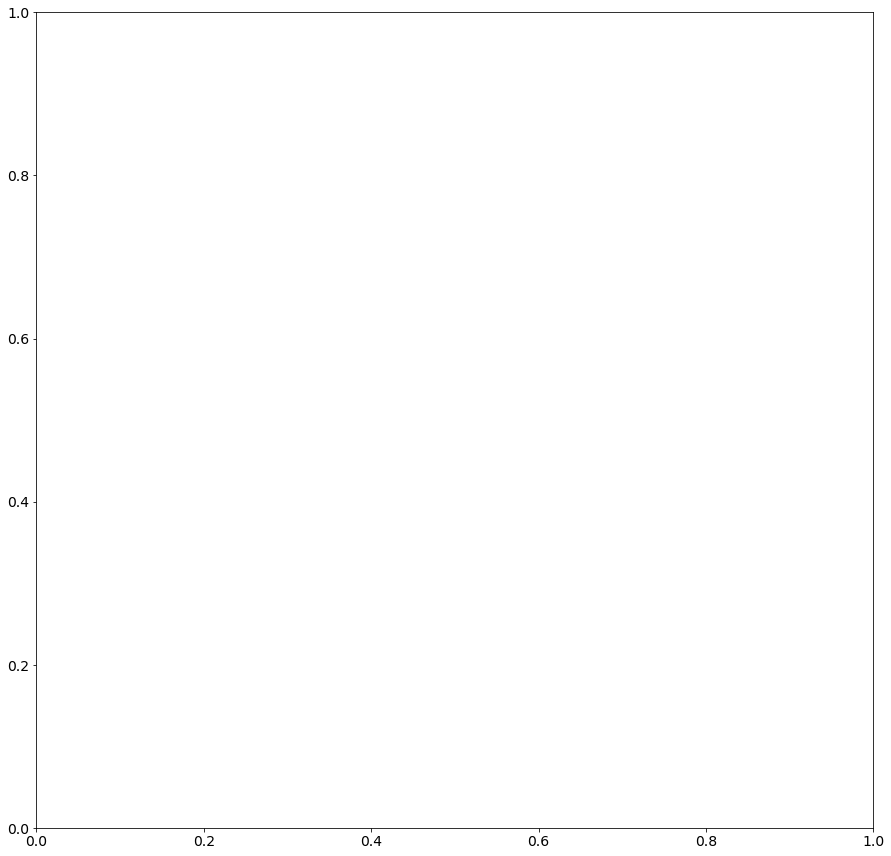

In [ ]:
#Performance Metrics for BiLSTM
y_test_pred = np.argmax(model3.predict(X_test), axis=-1)
print(f"Accuracy Score: {accuracy_score(y_test, y_test_pred) * 100:.2f}%")
print(f"F1 Score: {f1_score(y_test, y_test_pred, average='weighted') * 100:.2f}%")
print(f"Recall Score: {recall_score(y_test, y_test_pred, average='weighted') * 100:.2f}%")
print(f"Precision Score: {precision_score(y_test, y_test_pred, average='weighted') * 100:.2f}%")
from sklearn.metrics import matthews_corrcoef
print(f'MCC Score: {matthews_corrcoef(y_test, y_test_pred):.2f}%')
cm=confusion_matrix(y_test_pred, y_test,normalize='true')
cmd = ConfusionMatrixDisplay(cm, display_labels=labels_n)
fig, ax = plt.subplots(figsize=(15,15))
cmd.plot(ax=ax,cmap=plt.cm.Blues,colorbar=False)
filename ='bilstm_confmx '+datetime.now().strftime("%m-%d-%Y_%H-%M-%S")+'.jpg'
plt.savefig(filename, dpi=300)
FILE.download(filename)

In [ ]:
#@title Accuracy-loss for BiLSTM
plt.rcParams['font.family']='Arial'
plt.rcParams['font.size']=14
plt.plot(hist_bilstm.history['accuracy'])
plt.plot(hist_bilstm.history['val_accuracy'])
plt.plot(hist_bilstm.history['loss'])
plt.plot(hist_bilstm.history['val_loss'])

plt.title('BILSTM MODEL')
plt.ylabel('Accuracy/loss')
plt.xlabel('Epoch')
plt.legend(['train accuracy', 'val accuracy','train loss',' val loss'], loc='center right')
filename ='bilstm_acc_loss '+datetime.now().strftime("%m-%d-%Y_%H-%M-%S")+'.jpg'

plt.savefig(filename, dpi=300)
FILE.download(filename)
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

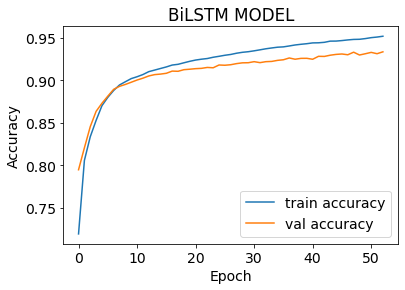

In [ ]:
plt.plot(hist_bilstm.history['accuracy'])
plt.plot(hist_bilstm.history['val_accuracy'])
plt.title('BiLSTM MODEL')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train accuracy', 'val accuracy'], loc='lower right')
filename ='bilstm_acc '+datetime.now().strftime("%m-%d-%Y_%H-%M-%S")+'.jpg'

plt.savefig(filename, dpi=300)
FILE.download(filename)
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

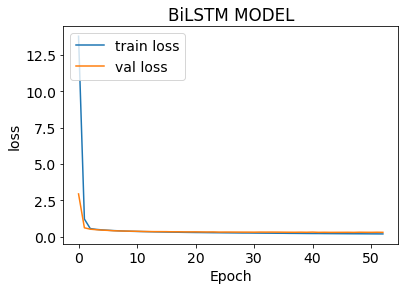

In [ ]:
plt.plot(hist_bilstm.history['loss'])
plt.plot(hist_bilstm.history['val_loss'])
plt.title('BiLSTM MODEL')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['train loss', 'val loss'], loc='upper left')
filename ='bilstm_loss '+datetime.now().strftime("%m-%d-%Y_%H-%M-%S")+'.jpg'

plt.savefig(filename, dpi=300)
FILE.download(filename)
plt.show()